# Generating feature visualizations

## Copyright notice

This version (c) 2018 Fabian Offert, license: [CC-BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

## Running this notebook as a REST API

This notebook can be run in the usual Jupyter way, by executing cells subsequently. To facilitate the exploration of the space of visualizations for non-experts, however, this notebook also provides a REST API through the [`jupyter-kernelgateway`](https://github.com/jupyter/kernel_gateway) package. The `jupyter-kernelgateway` package implements a simple way to turn notebooks into APIs, avoiding the many incomptabilities of Jupyter and, for instance, Flask. This way the literal style of the code can be kept, while also providing a way to run it as a microservice without any modifications.

### With manual installations

In a terminal, change into the directory of this notebook and run:

`
jupyter kernelgateway --KernelGatewayApp.api='kernel_gateway.notebook_http' --KernelGatewayApp.seed_uri='backend.ipynb' --port=6006 --KernelGatewayApp.allow_origin=*
`

The port 6006 in this example is arbitrary and can be switched for any open port. The API can now be accessed from the local host. To make it accessible from the network, add the `--ip=*` parameter. Only use this setting if you know what you are doing. The `--KernelGatewayApp.allow_origin=*` parameter makes sure that the API send CORS headers so the generated images can be accessed by the frontend. To start the frontend, simply open the [interface.html](interface.html) file.

### With installations using Docker

Install Docker and run either [run_GPU.sh](docker/run_GPU.sh) or [run_CPU.sh](docker/run_CPU.sh. The notebook server should be exposed on port 8888, the API should be exposed on port 6006 (this can be changed in the Dockerfile). To start the frontend, simply open the [interface.html](interface.html) file.

## Imports

Please refer to the [README.md](README.md) for proper installation of the dependencies listed here.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import scipy
from scipy.ndimage.filters import median_filter
from scipy.ndimage import zoom
from io import BytesIO
import PIL.Image
from IPython.display import clear_output, Image, display
import os
import random
import json

from keras import backend as K
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array

from queue import PriorityQueue
from threading import Thread
import uuid

Using TensorFlow backend.


## Settings

The default settings provide good results for both the InceptionV3 and the VGG16 architectures.

- `arch_or_file`: Set to either a valid Keras model file location, or to a valid implemented Keras model architecture. The latter setting will load this architecture with its respective ImageNet weights. Currently implemented architectures are `InceptionV3` and `VGG16`.
- `iterations`: How many iterations of gradient ascent to do per octave.
- `step`: Step size
- `median_every`: Regularization term. How often to apply a [median filter](https://en.wikipedia.org/wiki/Median_filter) to the image during gradient ascent (every `median_every` iterations).
- `median_fsize`: Regularization term. Size of the median filter kernel.
- `octaves`: How many octaves, i.e. how many different scales of the image, to process.
- `octaves_scale`: How big is the increase in image size between octaves.
- `final_size`: Size of the image after the last octave.

In [2]:
# These settings are always used
arch_or_file = 'portrait-landscape-stilllife-v3-10.hdf5'
iterations = 100
step = 0.01
median_every = 4
median_fsize = 5
octaves = 10
octave_scale = 1.2
final_size = 900

# These are only used when running standalone
layer = 'predictions'
neuron = 0
octave = 10

## Image helper functions

These functions provide some simple image transformations..

In [3]:
# Normalizes an image array from the -1/1 value space to the 0/255 value space.
def deprocess_img(img, autotone=True):
    img /= 2.
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype('uint8') # Clip to visible range
    if (autotone): img = autotone_img(img)
    return img

# Saves a normalized image array as a regular image file.
def save_img(img, filename, fmt='jpeg'): 
    PIL.Image.fromarray(img).save(filename, fmt)

# Resizes an imge array. Supports n-dimensional batches.
def resize_img(img, size):
    factors = np.ones(shape=len(img.shape), dtype=np.float)
    factors[-2] = float(size[1]) / img.shape[-3]
    factors[-3] = float(size[0]) / img.shape[-2]
    img = np.copy(img)
    factors = tuple(factors.tolist())
    return zoom(img, factors, order=1)

# Applies a median filter to an image array. Supports n-dimensional batches.
def median_filter_img(img, fsize):
    factors = np.ones(shape=len(img.shape), dtype=np.int)
    factors[-2] = fsize
    factors[-3] = fsize
    factors = tuple(factors.tolist())
    return median_filter(img, size=factors)

# Shows a normalized image array in the cell output.
def show_img(img, fmt='jpeg'):
    f = BytesIO()
    PIL.Image.fromarray(img).save(f, fmt)
    display(Image(data=f.getvalue()))
    
# Normalizes each color of an image array sepearately ("Photoshop auto tone").
def autotone_img(img):
    img[:,:,0] = np.interp(img[:,:,0], [np.amin(img[:,:,0]), np.amax(img[:,:,0])], [0, 255])
    img[:,:,1] = np.interp(img[:,:,1], [np.amin(img[:,:,1]), np.amax(img[:,:,1])], [0, 255])
    img[:,:,2] = np.interp(img[:,:,2], [np.amin(img[:,:,2]), np.amax(img[:,:,2])], [0, 255])
    return img

## Main activation loop

The main operations to generate the feature visualization images are contained in a single function so they can be run in a separate thread (important if the notebook is run in API mode). Please refer to the inline commentary.

In [4]:
def generate_activation(q):
    
    # Load model inside thread to avoid confusing Keras
    model = None
    # Is this a valid architecture?
    if (arch_or_file == 'InceptionV3'): model = InceptionV3(weights='imagenet', include_top=True)
    elif (arch_or_file  == 'VGG16'): model = VGG16(weights='imagenet', include_top=True)
    else:
        # Is this a valid Keras model file?
        try: model = load_model(arch_or_file)
        except: 
            raise FileNotFoundError('First parameter is not valid Keras architecture or valid Keras model file.')
            return
    model_list = [layer.name.lower() for layer in model.layers]
    model_dict = dict([(layer.name.lower(), layer) for layer in model.layers])
    model_json = dict([(layer.name.lower(), layer.output_shape[-1]) for layer in model.layers])
        
    # Persistent graph edits
    loss = K.variable(0.)
    input_layer = model.layers[0].input 
        
    while True:

        layer, neuron, variations, octave, path_to_img = q.get()[1] # Ignore the priority item
        
        # If there are no jobs to do, loop
        if neuron is None:
            break
        
        # If layer is invalid, scrap this job and loop
        if layer not in model_list:
            raise KeyError('Layer ' + layer + ' is not part of model ' + arch_or_file + '.')
            q.task_done()
            break

        # Is this a classification layer?
        predictions = False
        if (layer.lower() == 'predictions'):
            predictions = True

        target_layer = model_dict[layer].output
        # We stack an additional dimension to generate activations in batches
        # We avoid border artifacts by only involving non-border pixels in the loss
        if (predictions): loss = K.stack([model.layers[-1].output[i, neuron] for i in range(variations)])
        else: loss = K.stack([K.sum(K.mean(target_layer[i, 2:-2, 2:-2, neuron])) for i in range(variations)])  
        grads = K.gradients(loss, input_layer)[0] # Compute gradients from loss
        grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon()) # Normalize
        fetch_loss_and_grads = K.function([input_layer], [loss, grads]) # As Keras function

        # Input noise image
        img = np.random.normal(0, 0.01, (variations, final_size, final_size, 3))

        # Explicitly copy octave list and cut to only generate up to desired octave for this neuron
        successive_shapes = list(all_successive_shapes[:octave])

        # Excplicitly copy noise image
        final_img = np.copy(img)
        
        # Do octaves
        shrunk_final_img = resize_img(img, successive_shapes[0])
        for shape in successive_shapes:

            # Resize current image to current shape
            img = resize_img(img, shape) 

            # Optimize current image w.r.t. selected layers with gradient ascent
            for i in range(iterations):

                # Get losses and gradients
                grad_values = fetch_loss_and_grads([img])[1]

                # Gradient ascent
                img += step * grad_values

                # Regularization
                # No regularization on last iteration for good quality output  
                if (i != iterations - 1):  
                    if (median_fsize is not 0 and i % median_every == 0) :
                        img = median_filter_img(img, median_fsize)
                
                # Save every iteration to show progress in interface
                deprocessed_img = deprocess_img(np.copy(img[0]))
                save_img(deprocessed_img, path_to_img)

            # Resize ("upscale") previous shape original image to current shape
            upscaled_shrunk_final_img = resize_img(shrunk_final_img, shape)

            # Resize ("downscale") original shape original image to current shape
            same_size_final_img = resize_img(final_img, shape)

            # Find the details that are lost in the upscaling process
            lost_detail = same_size_final_img - upscaled_shrunk_final_img

            # Add these details back to the optimized image
            img += lost_detail # Add back the lost details to the optimized image

            # Prepare for next ocatve
            shrunk_final_img = resize_img(final_img, shape)

        deprocessed_img = deprocess_img(np.copy(img[0]))
            
        # Show image if not in API mode
        if 'KERNEL_GATEWAY' not in os.environ:
            show_img(deprocessed_img) 
            
        # Save image
        save_img(deprocessed_img, path_to_img)
        
        # Remove from queue
        q.task_done()

In [5]:
# Prepare priority queue and thread
if not os.path.exists('images'): os.makedirs('images')
q = PriorityQueue()
t = Thread(target=generate_activation, args=(q,))
t.start()

# Prepare octaves, they are the same for all neurons/layers
final_shape = (final_size, final_size)
all_successive_shapes = [final_shape]
for i in range(1, octaves):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in final_shape])
    all_successive_shapes.append(shape)
# Reverse the list so we go small to final
all_successive_shapes = all_successive_shapes[::-1]

# Prepare placeholders for all octaves
placeholders = []
for n, shape in enumerate(all_successive_shapes):
    wh = all_successive_shapes[n][0] # Images are always square
    img = np.random.normal(0, 0.01, (wh, wh, 3))
    img = deprocess_img(img)
    placeholders.append(img)

## REST resource/main loop

The `jupyter-kernelgateway` package routes API requests according to the first comment line. If we are not in API mode, the global notebook settings are used.

images/1a1e5f89-28f6-4d9a-931d-cc2de07dbcb2.jpg


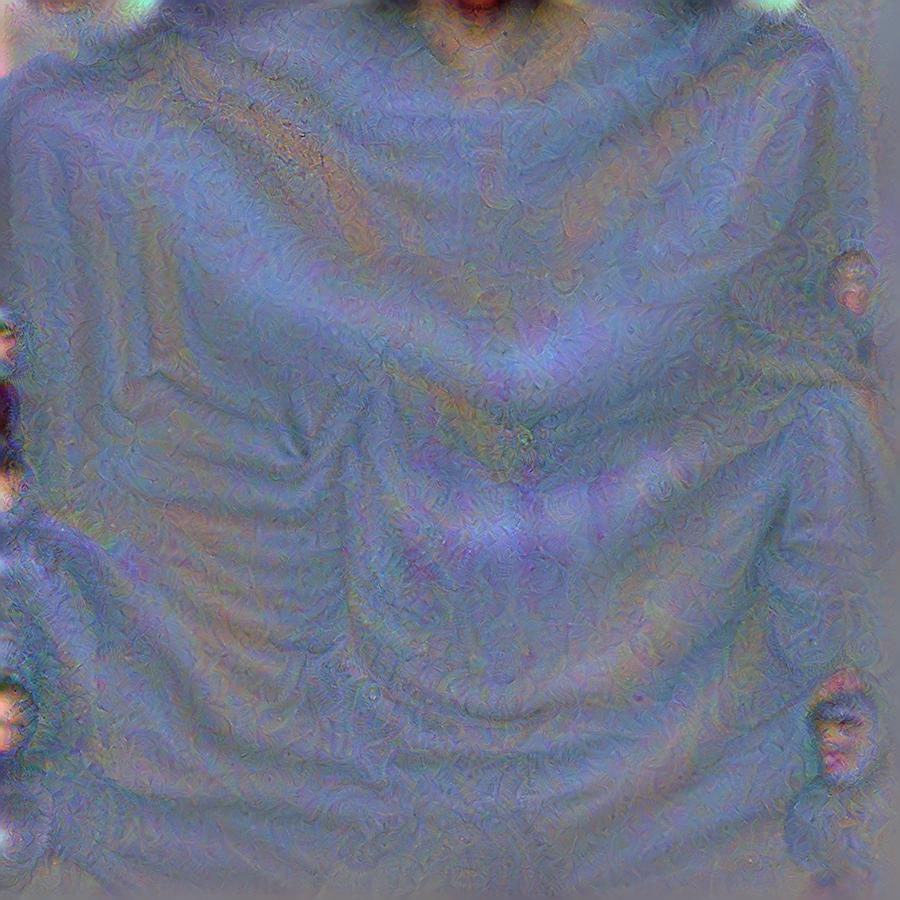

In [6]:
# GET /activations/:layer/:neuron/:octave

variations = 1
# Check if we are running in API mode
if 'KERNEL_GATEWAY' in os.environ:
    # Extract parameters from path
    r = json.loads(REQUEST)
    layer = r['path']['layer']
    neuron = int(r['path']['neuron'])
    variations = 1
    octave = int(r['path']['octave'])

# Generate unique image ID
path_to_img = 'images/' + str(uuid.uuid4()) + '.jpg'
# Write placeholder image
save_img(placeholders[octave-1], path_to_img)
# Return image path              
print(path_to_img)
# Start generating activation
q.put((11-octave, (layer, neuron, variations, octave, path_to_img))) # 11 So priority is at least 1!